## 1. Preliminary Steps

In this section, we import the necessary Python libraries and load the startup funding dataset.

The dataset contains:

basic startup information (name, founding year, sector, location),

founder information stored as text in a Founder/s column,

funding amount and funding stage.

We will use this dataset to study how number of founders, funding stage, and founding year relate to total funding.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

df = pd.read_csv("startupdataset.csv", encoding="latin-1")
df.head()


,ï»¿Company/Brand,Founded,Headquarters,Sector,What it does,Founder/s,Investor/s,Amount(in dollars),Stage,Month
0,CollegeDekho,2015.0,Gurgaon,E-learning,"Collegedekho.com is Studentâs Partner, Frien...",Ruchir Arora,"Disrupt ADQ, QIC",35000000,Series B,12
1,BOX8,2012.0,Mumbai,Food & Beverages,India's Largest Desi Meals Brand,"Anshul Gupta, Amit Raj",Tiger Global,40000000,NaN,12
2,Simpl,2015.0,Bangalore,Consumer Services,Simpl empowers merchants to build trusted rela...,"Nitya, Chaitra Chidanand","Valar Ventures, IA Ventures",40000000,Series B,12
3,8i Ventures,2018.0,Mumbai,Venture Capital & Private Equity,8i is a Mumbai & Bangalore based early stage f...,Vikram Chachra,NaN,50000000,NaN,12
4,PayGlocal,2021.0,Bangalore,Financial Services,PayGlocal is a FinTech solving for global paym...,"Prachi Dharani, Rohit Sukhija, Yogesh Lokhande",Sequoia Capital India,4900000,Series A,12


**Note on encoding (`encoding="latin-1"`):**  
The original CSV file from Kaggle contained special characters and a BOM (byte order mark) in the first column name (e.g., `ï»¿Company/Brand`).  
Using `encoding="latin-1"` allows pandas to read the file without raising UnicodeDecodeError and preserves all characters correctly.  
After loading, we manually clean and rename the affected column to a proper `Company/Brand` header during the data cleaning step.


### Data Cleaning and Feature Engineering

In this step, we:

Fix encoding issues in column names (e.g., BOM characters in Company/Brand).

Strip whitespace from column names.

Convert the funding amount from a string field (Amount(in dollars)) to a numeric variable Amount_clean.

Engineer new features:

founder_count: number of founders per startup, derived from the Founder/s text field.

log_amount: log₁₀-transformed funding for more stable visualizations.

Founded_year: numeric version of the founding year, where available.

Create a cleaned working dataset df_clean that includes only rows with valid funding and stage information.

In [2]:
# Clean column names
df.columns = df.columns.str.strip()
df.rename(columns={df.columns[0]: "Company/Brand"}, inplace=True)  # fix BOM in first column if present

# --- Feature: founder_count ---
def count_founders(value):
    if pd.isna(value):
        return 0
    s = str(value).strip()
    if s == "":
        return 0

    # Remove outer quotes
    s = s.strip('"').strip("'")
    # Normalize separators
    s = s.replace(" and ", ",")
    s = s.replace("&", ",")

    parts = [p.strip() for p in s.split(",") if p.strip() != ""]
    return len(parts)

df["founder_count"] = df["Founder/s"].apply(count_founders)

# --- Feature: Amount_clean (numeric funding) ---
df["Amount_clean"] = (
    df["Amount(in dollars)"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.replace("$", "", regex=False)
    .str.strip()
    .replace("", np.nan)
)
df["Amount_clean"] = pd.to_numeric(df["Amount_clean"], errors="coerce")

# --- Feature: log_amount (log10 funding) ---
df["log_amount"] = np.log10(df["Amount_clean"] + 1)

# --- Feature: Founded_year ---
df["Founded_year"] = pd.to_numeric(df["Founded"], errors="coerce")

# Filter to analysis dataset: non-missing funding amount and stage
df_clean = df.dropna(subset=["Amount_clean", "Stage"]).copy()

df_clean[["Company/Brand", "founder_count", "Amount_clean", "Stage"]].head()


,Company/Brand,founder_count,Amount_clean,Stage
0,CollegeDekho,1,35000000.0,Series B
2,Simpl,2,40000000.0,Series B
4,PayGlocal,3,4900000.0,Series A
6,Pocket FM,3,22000000.0,Series B
8,PlanetSpark,2,13000000.0,Series B


## 2. Dataset Overview

Here we take a first look at the cleaned dataset.
We display the first few rows and inspect the structure using .info() and .describe().

Each row represents a startup, with columns describing founding team size (founder_count), funding amount (Amount_clean), funding stage (Stage), sector (Sector), and founding year (Founded_year).
This overview helps us understand data types, missing values, and basic ranges before more detailed analysis.

In [3]:
print(df_clean.head())
print("\nINFO:")
print(df_clean.info())
print("\nDESCRIBE (key numeric columns):")
print(df_clean[["founder_count", "Amount_clean", "log_amount", "Founded_year"]].describe())


  Company/Brand  Founded Headquarters                Sector  \
0  CollegeDekho   2015.0      Gurgaon            E-learning   
2         Simpl   2015.0    Bangalore     Consumer Services   
4     PayGlocal   2021.0    Bangalore    Financial Services   
6     Pocket FM   2018.0    Bangalore                   OTT   
8   PlanetSpark   2017.0     Gurugram  Education Management   

                                        What it does  \
0  Collegedekho.com is Studentâs Partner, Frien...   
2  Simpl empowers merchants to build trusted rela...   
4  PayGlocal is a FinTech solving for global paym...   
6  Pocket FM lets users discover and enjoy the gr...   
8  PlanetSpark is building the World Leader in Co...   

                                        Founder/s  \
0                                    Ruchir Arora   
2                        Nitya, Chaitra Chidanand   
4  Prachi Dharani, Rohit Sukhija, Yogesh Lokhande   
6         Rohan, Nishanth Srinivas, Prateek Dixit   
8                  

## 3. Summary Statistics

In this section, we compute key summary statistics for the main variables of interest:

founder_count (number of founders),

Amount_clean (total funding),

log_amount (log-transformed funding),

Founded_year (where available).

We also examine the distribution of categorical variables such as Stage and Sector.
These statistics provide a high-level picture of typical team sizes, funding levels, and temporal coverage.

In [5]:

summary_stats = df_clean[["founder_count", "Amount_clean", "log_amount", "Founded_year"]].agg(
    ["mean", "median", "min", "max", "std"]
).T
summary_stats.columns = ["Mean", "Median", "Min", "Max", "Standard Deviation"]

founder_counts = df_clean["founder_count"].value_counts().sort_index()
print(founder_counts)


most_common_founder_count = df_clean["founder_count"].value_counts().idxmax()
most_common_founder_count


print(summary_stats)

# Skewness for funding-related variables
print("\nSkewness:")
print(df_clean[["Amount_clean", "log_amount"]].skew())

# Categorical distributions
print("\nStage distribution:")
print(df_clean["Stage"].value_counts())

print("\nTop 10 sectors by frequency:")
print(df_clean["Sector"].value_counts().head(10))


founder_count
0      4
1    221
2    299
3    130
4     34
5      6
6      1
Name: count, dtype: int64
                       Mean        Median            Min           Max  \
founder_count  1.987050e+00  2.000000e+00       0.000000  6.000000e+00   
Amount_clean   2.384305e+08  3.000000e+06  100000.000000  1.500000e+11   
log_amount     6.601539e+00  6.477121e+00       5.000004  1.117609e+01   
Founded_year   2.017192e+03  2.018000e+03    1989.000000  2.021000e+03   

               Standard Deviation  
founder_count        9.085596e-01  
Amount_clean         5.689322e+09  
log_amount           8.241826e-01  
Founded_year         3.549183e+00  

Skewness:
Amount_clean    26.357899
log_amount       0.570149
dtype: float64

Stage distribution:
Stage
Seed             201
Pre-series A     129
Series A         125
Series B          47
Series C          44
Pre-seed          37
Debt              27
Series D          21
Series E          17
Pre-series B      10
Pre-Series A       9
Series F  

**Conclusion from univariate analysis of `founder_count`:**  
Based on the frequency distribution, the most common founding team size in this dataset is **2 founders**.  
This suggests that startups are most often founded by small teams rather than solo founders or very large founding teams.


## 4. Founder Count vs Funding Amount

This section examines whether startups with more founders tend to raise more funding.

Steps:

Group by founder_count to compute the number of startups, mean funding, and median funding.

Visualize funding distributions using boxplots of Amount_clean and log_amount across different founder counts.

These summaries help answer RQ1: “Is there a relationship between a startup’s number of founders and its total funding amount?”

In [6]:
funding_by_founders = (
    df_clean.groupby("founder_count")["Amount_clean"]
    .agg(["count", "mean", "median"])
    .sort_index()
)

print(funding_by_founders)


               count          mean     median
founder_count                                
0                  4  3.200000e+06  1250000.0
1                221  6.988303e+08  3000000.0
2                299  2.287905e+07  3500000.0
3                130  2.423931e+07  3750000.0
4                 34  2.860971e+07  5000000.0
5                  6  4.820000e+07  3400000.0
6                  1  1.000000e+06  1000000.0


In [ ]:
#### Boxplot: raw funding amount by founder count

The goal here is to compare the **distribution** of funding amounts for different founder team sizes.

A boxplot for each `founder_count` shows:
- the **median** (middle line in the box),
- the **interquartile range (IQR)** (the height of the box, from 25th to 75th percentile),
- the "whiskers" (typical minimum and maximum values),
- and **outliers** (points far away from the rest).

By plotting `Amount_clean` (the raw funding amounts) against `founder_count`, we can visually check:
- whether teams with more founders tend to have higher typical funding,
- how spread out the funding is within each group,
- and whether there are extreme high-funding startups (outliers) for certain founder counts.


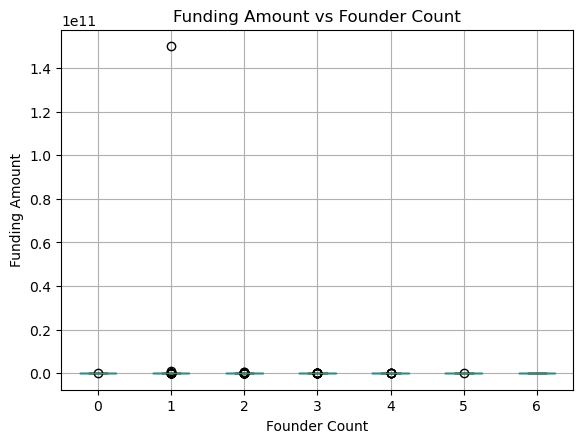

In [8]:
# Boxplot with raw funding
df_clean.boxplot(column="Amount_clean", by="founder_count")
plt.xlabel("Founder Count")
plt.ylabel("Funding Amount")
plt.title("Funding Amount vs Founder Count")
plt.suptitle("")
plt.show()


In [ ]:
#### Boxplot: log-transformed funding by founder count

Funding amounts can vary a lot: some startups raise relatively small rounds, while a few raise extremely large amounts.  
When we plot the **raw** funding values, these very large values can "stretch" the scale so much that most companies look squeezed at the bottom of the plot.

To fix this, we use a **log transformation**:

- We created `log_amount = log10(Amount_clean + 1)`.
- This does not change the order of startups (bigger funding is still bigger),
- but it **compresses very large values** and makes differences between small and medium values easier to see.

In this boxplot:
- Each box still represents the distribution of funding for each `founder_count`,
- but now on a **log10 scale**, where:
  - a difference of 1 unit means about **10× more funding**,
  - a difference of 2 units means about **100× more funding**.

Using the log scale helps us:
- compare groups more clearly,
- see patterns (e.g., whether 2–4 founders have systematically higher typical funding),
- without being dominated by a few extreme outliers.


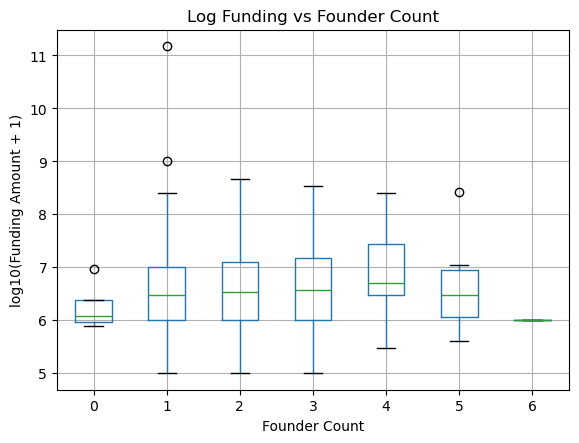

In [9]:
# Boxplot with log funding
df_clean.boxplot(column="log_amount", by="founder_count")
plt.xlabel("Founder Count")
plt.ylabel("log10(Funding Amount + 1)")
plt.title("Log Funding vs Founder Count")
plt.suptitle("")
plt.show()

In [ ]:
## 5. Funding Stage vs Funding Amount

Here we study how funding amounts differ across funding stages (Pre-seed, Seed, Series A, Series B, etc.).

Steps:

Group by Stage and compute counts and median log funding.

Restrict analysis to stages with sufficient observations (e.g., at least 5 startups).

Plot boxplots of log_amount by Stage.

This section addresses RQ2: “Is there a relationship between funding stage and total funding amount?”

                 n  median_log_amount  mean_log_amount
Stage                                                 
Series H         2           8.715682         8.715682
Series F         6           8.340621         8.327421
Series G         2           8.070442         8.070442
Series D        21           8.000000         7.857790
PE               1           8.000000         8.000000
Series E        17           8.000000         7.957222
Series I         1           7.880814         7.880814
Series C        44           7.698970         7.660819
Series D1        1           7.612784         7.612784
Series B        47           7.397940         7.433884
Series A2        1           7.176091         7.176091
Series B3        1           7.155336         7.155336
Pre-series       2           7.112655         7.112655
Series A+        1           6.929419         6.929419
Series F1        1           6.845098         6.845098
Series A       125           6.819544         6.897731
Debt      

<Figure size 800x400 with 0 Axes>

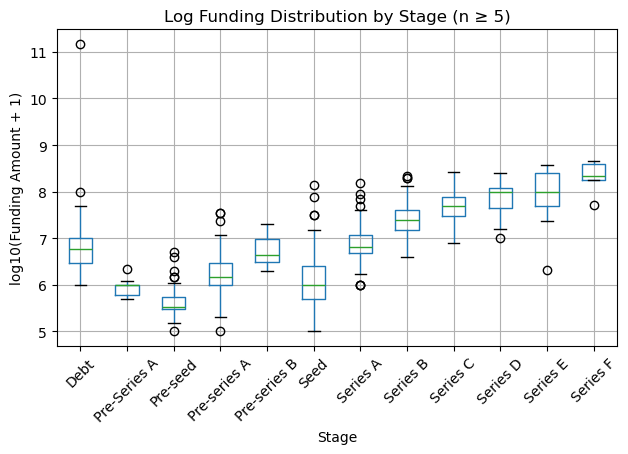

In [11]:
stage_summary = (
    df_clean.groupby("Stage")
    .agg(
        n=("Amount_clean", "size"),
        median_log_amount=("log_amount", "median"),
        mean_log_amount=("log_amount", "mean")
    )
    .sort_values("median_log_amount", ascending=False)
)

print(stage_summary)

# Keep only stages with enough data points (e.g., n >= 5)
common_stages = stage_summary[stage_summary["n"] >= 5].index
df_stage_common = df_clean[df_clean["Stage"].isin(common_stages)].copy()

plt.figure(figsize=(8, 4))
df_stage_common.boxplot(column="log_amount", by="Stage", rot=45)
plt.ylabel("log10(Funding Amount + 1)")
plt.title("Log Funding Distribution by Stage (n ≥ 5)")
plt.suptitle("")
plt.tight_layout()
plt.show()



## 6. Sector and Founded Year Patterns

In this section, we:

Explore how funding levels vary across sectors.

Investigate whether the founding year is related to funding amount.

This helps contextualize funding outcomes with respect to industry and time.

                                     count          mean        median
Sector                                                                
Innovation Management                    1  1.000000e+09  1.000000e+09
Social media                             1  2.660000e+08  2.660000e+08
Finance                                  3  1.669333e+08  2.500000e+08
Home services                            1  2.500000e+08  2.500000e+08
Cloud kitchen                            1  1.750000e+08  1.750000e+08
Mechanical & Industrial Engineering      1  1.500000e+08  1.500000e+08
D2C Business                             1  1.500000e+08  1.500000e+08
Crypto                                   2  1.307500e+08  1.307500e+08
BioTechnology                            2  1.000000e+08  1.000000e+08
Construction                             3  7.518333e+07  1.000000e+08


<Figure size 900x400 with 0 Axes>

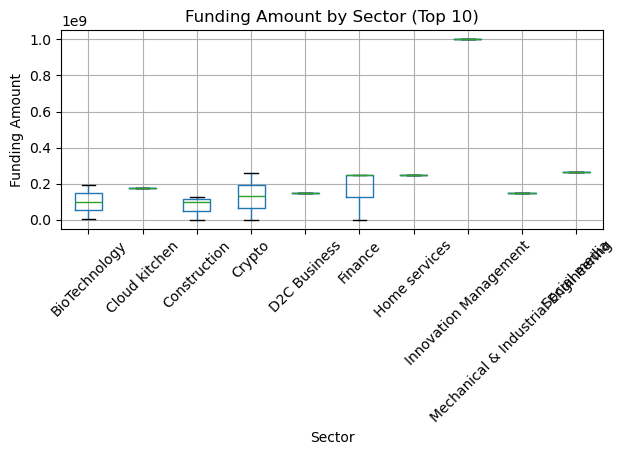

In [12]:
# Funding by sector (top 10 by median funding)
funding_by_sector = (
    df_clean.groupby("Sector")["Amount_clean"]
    .agg(["count", "mean", "median"])
    .sort_values("median", ascending=False)
)

print(funding_by_sector.head(10))

top_sectors = funding_by_sector.head(10).index
df_top_sector = df_clean[df_clean["Sector"].isin(top_sectors)].copy()

plt.figure(figsize=(9, 4))
df_top_sector.boxplot(column="Amount_clean", by="Sector", rot=45)
plt.ylabel("Funding Amount")
plt.title("Funding Amount by Sector (Top 10)")
plt.suptitle("")
plt.tight_layout()
plt.show()


              Founded_year  Amount_clean
Founded_year      1.000000      0.006232
Amount_clean      0.006232      1.000000


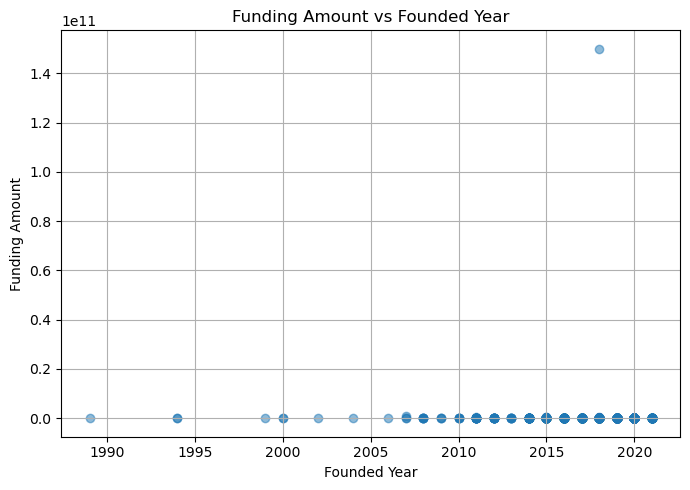

In [13]:
# Correlation and scatter plot: Founded_year vs Amount_clean
print(df_clean[["Founded_year", "Amount_clean"]].corr())

plt.figure(figsize=(7, 5))
plt.scatter(df_clean["Founded_year"], df_clean["Amount_clean"], alpha=0.5)
plt.xlabel("Founded Year")
plt.ylabel("Funding Amount")
plt.title("Funding Amount vs Founded Year")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
### 7. Correlation Analysis

In this step, we quantify the linear relationships between our main numeric variables:

- `founder_count` – number of founders  
- `Amount_clean` – total funding amount  
- `log_amount` – log10-transformed funding  
- `Founded_year` – year the startup was founded  

We use the **Pearson correlation coefficient**.  
Pearson correlation measures **linear** association between two variables:

- Values close to **+1** → strong positive linear relationship  
- Values close to **-1** → strong negative linear relationship  
- Values near **0** → little or no linear relationship  

First, we compute and print the numeric correlation matrix. Then, we visualize it with a heatmap for easier interpretation.


In [15]:
# Correlation matrix using Pearson correlation
corr_matrix = df_clean[["founder_count", "Amount_clean", "log_amount", "Founded_year"]].corr(method="pearson")
print(corr_matrix)


               founder_count  Amount_clean  log_amount  Founded_year
founder_count       1.000000     -0.040797    0.071186      0.041413
Amount_clean       -0.040797      1.000000    0.217554      0.006232
log_amount          0.071186      0.217554    1.000000     -0.286458
Founded_year        0.041413      0.006232   -0.286458      1.000000


In [ ]:
#### heatmap

The heatmap below visualizes the Pearson correlation matrix:

- **Red** cells indicate positive relationships (when one variable increases, the other tends to increase).  
- **Blue** cells indicate negative relationships (when one increases, the other tends to decrease).  
- The color intensity reflects the strength of the relationship; values are also shown as numbers inside each cell.

This helps us quickly see, for example:

- how strongly funding (`Amount_clean` and `log_amount`) is related to `founder_count`,  
- whether `Founded_year` is associated with funding,  
- and how similar `Amount_clean` and `log_amount` are to each other (they should be highly positively correlated).


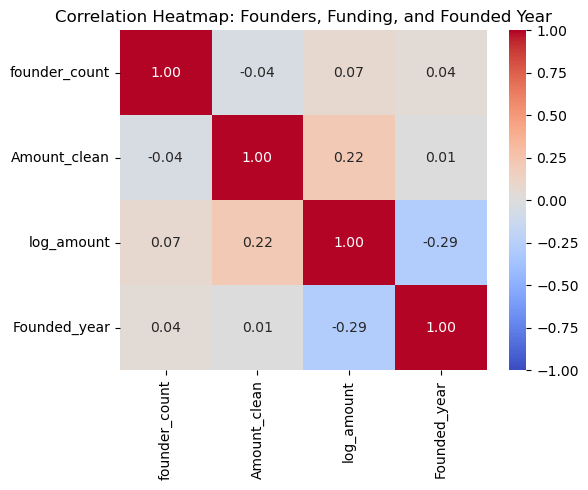

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_matrix,
    annot=True,        # show correlation values
    fmt=".2f",         # 2 decimal places
    cmap="coolwarm",   # blue = negative, red = positive
    vmin=-1, vmax=1    # fix scale from -1 to 1
)
plt.title("Correlation Heatmap: Founders, Funding, and Founded Year")
plt.tight_layout()
plt.show()


In [ ]:
## 8. Summary of Exploratory Data Analysis (EDA)

In this EDA, we examined how founder count, funding stage, sector, and founding year relate to startup funding amounts.

Key steps:

Cleaned and transformed the raw dataset into a structured analysis-ready form.

Engineered features such as founder_count, Amount_clean, log_amount, and Founded_year.

Performed univariate analysis to understand basic distributions of funding and team sizes.

Used group summaries and boxplots to study:

the relationship between founder count and funding amount,

how funding scales with funding stage,

variations in funding across sectors.

Investigated temporal patterns via founded year and basic correlation analysis.

These results form the basis for answering the project’s main research questions about how founding team structure and funding stage relate to investment outcomes.